In [1]:
from qpe import *
from numpy import log, ones, full

import qutip as qp
from time import time

from numpy import sign, ceil
from numpy.random import randint

from scipy.stats import unitary_group, gaussian_kde
from scipy.linalg import logm
from scipy import sparse

import pennylane as qml

import pickle

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 20})
# matplotlib.rcParams['axes.unicode_minus']=False
# matplotlib.rcParams['font.family']='serif'
# matplotlib.rc('text', usetex=False)

# Ising Ham ground state

In [2]:
I_sp = sparse.csr_array(I)
X_sp = sparse.csr_array(X)
Y_sp = sparse.csr_array(Y)
Z_sp = sparse.csr_array(Z)

In [3]:
def ising_ham(n_qubits, h, J=1, bc="closed"):
    d = 2**n_qubits
    Hx = zeros((d, d), dtype=complex)
    for q in range(n_qubits):
        X_op = [eye(2**q)] + [X] + [eye(2**(n_qubits - q - 1))]
        Hx = Hx + reduce(kron, X_op)
    Hzz = zeros((d, d), dtype=complex)
    for q in range(n_qubits - 1):
        Hzz = Hzz + reduce(kron, [eye(2**q)] + [Z, Z] + [eye(2**(n_qubits - q - 2))])
    if bc == "closed" and n_qubits > 2:
        Hzz = Hzz + reduce(kron, [Z] + [eye(2**(n_qubits - 2))] + [Z])
    if n_qubits == 1: # lame
        Hzz = 1*Z
    return -J*(Hzz + h*Hx)

def ising_ham_sparse(n, h, J=1, bc="closed"):
    d = 2**n
    Hx = sparse.csr_array(zeros([d, d]))
    for q in range(n):
        Hx = Hx + reduce(sparse.kron, [sparse.eye(2**q), X_sp, sparse.eye(2**(n - q - 1))])
    Hzz = sparse.csr_array(zeros([d, d]))
    for q in range(n - 1):
        Hzz = Hzz + reduce(sparse.kron, [sparse.eye(2**q), Z_sp, Z_sp, sparse.eye(2**(n - q - 2))])
    if bc == "closed" and n > 2:
        Hzz = Hzz + reduce(sparse.kron, [Z_sp, sparse.eye(2**(n - 2)), Z_sp])
    if n == 1: # lame
        Hzz = 1*Z_sp
    return -J*(Hzz + h*Hx)

In [39]:
def proces_op_string(op_string):
    str_proc = ""
    for char in str(op_string):
        if char == "I":
            str_proc = str_proc + "–"
        elif char == "X":
            str_proc = str_proc + "X"
        elif char == "Y":
            str_proc = str_proc + "Y"
        elif char == "Z":
            str_proc = str_proc + "Z"
    return str_proc

## Pure

In [188]:
N = 4
l = 0.05
u = 5
T = 51

hs = linspace(l, u, T)
svs = []
dms = []
for h in hs:
    ham = ising_ham_sparse(N, h)
    sv = sparse.linalg.eigsh(ham, 1, which="SA")[1].reshape(-1)
    svs.append(sv)
    dms.append(outer(sv, sv.conj()))

In [189]:
# dm_decomp = qml.pauli_decompose(dms[int(T/2)])
dm_decomp = qml.pauli_decompose(dms[np.abs(hs - 1.).argmin()])
strings_list = [proces_op_string(str(op)) for op in dm_decomp.ops]

In [190]:
coeffs_list = zeros([T, len(strings_list)])
for i in range(T):
    dm_decomp = qml.pauli_decompose(dms[i])
    dm_coeffs = dm_decomp.coeffs
    dm_strings = [proces_op_string(str(op)) for op in dm_decomp.ops]
    # for string, coef in zip(dm_strings, dm_coeffs):
    #     ind = strings_list.index(string)
    #     coeffs_list[i][ind] = coef
    for j in range(len(dm_strings)):
        print(f"i: {i} | j: {j}", end="\r")
        ind = strings_list.index(dm_strings[j])
        coeffs_list[i][ind] = dm_coeffs[j]

i: 50 | j: 69

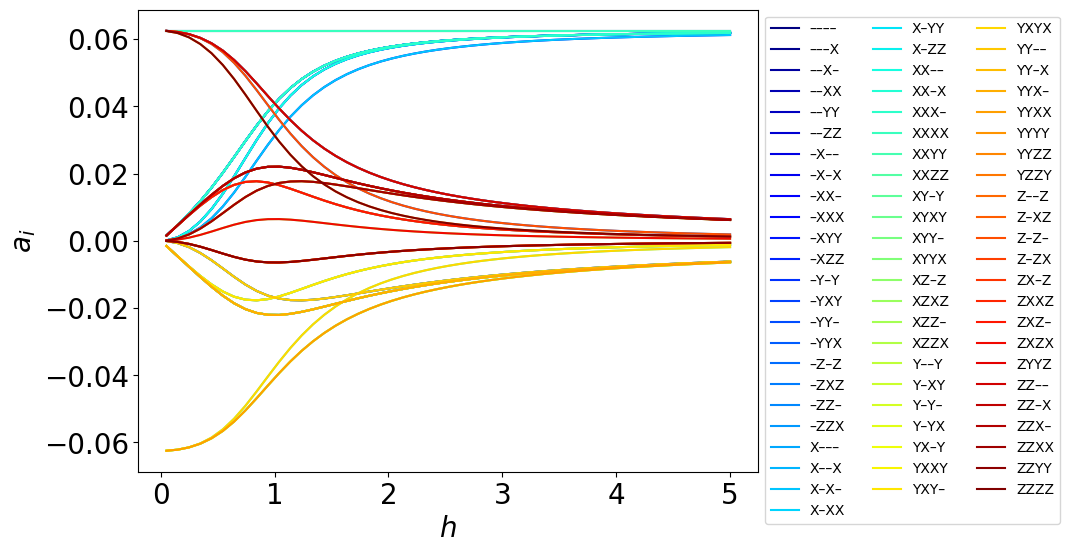

In [191]:
colors = plt.cm.jet(np.linspace(0, 1, len(strings_list)))
plt.figure(figsize=(8, 6))
for i in range(len(strings_list)):
    plt.plot(hs, coeffs_list.T[i], color=colors[i], label=strings_list[i]) # 
plt.xlabel(r"$h$")
plt.ylabel(r"$a_i$")
plt.legend(fontsize=10, ncol=3, bbox_to_anchor=(1, 1.0))
plt.show()

## Thermal

In [192]:
def thermal_ising(h, N, beta=1):
    exp_H = expm(-beta*ising_ham(N, h))
    # exp_H = expm(-beta*ising_ham_sparse(N, h))
    denom = trace(exp_H).real
    return exp_H/denom

In [193]:
N = 4
beta = 1e0
l = 0
u = 5
T = 50

hs = linspace(l, u, T)
dms = []
for h in hs:
    dms.append(thermal_ising(h, N, beta))

In [194]:
dm_decomp = qml.pauli_decompose(dms[-1])
strings_list = [proces_op_string(str(op)) for op in dm_decomp.ops]

In [195]:
coeffs_list = zeros([T, len(strings_list)])
for i in range(T):
    dm_decomp = qml.pauli_decompose(dms[i])
    dm_coeffs = dm_decomp.coeffs
    dm_strings = [proces_op_string(str(op)) for op in dm_decomp.ops]
    # for string, coef in zip(dm_strings, dm_coeffs):
    #     ind = strings_list.index(string)
    #     coeffs_list[i][ind] = coef
    for j in range(len(dm_strings)):
        print(f"i: {i} | j: {j}", end="\r")
        ind = strings_list.index(dm_strings[j])
        coeffs_list[i][ind] = dm_coeffs[j]

i: 49 | j: 69

In [196]:
# coeffs_list = array([qml.pauli_decompose(dm).coeffs for dm in dms])
# dm_decomp = qml.pauli_decompose(dms[-1])
# strings_list = [proces_op_string(str(op)) for op in dm_decomp.ops]

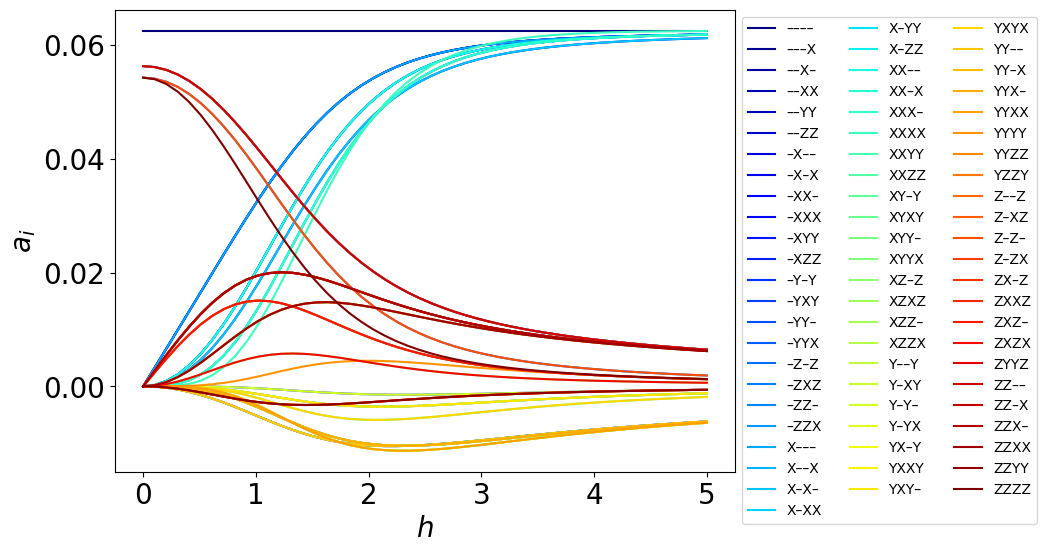

In [197]:
colors = plt.cm.jet(np.linspace(0, 1, len(strings_list)))
plt.figure(figsize=(8, 6))
for i in range(len(strings_list)):
    plt.plot(hs, coeffs_list.T[i], color=colors[i], label=strings_list[i]) # .replace("_", "\_")
plt.xlabel(r"$h$")
plt.ylabel(r"$a_i$")
plt.legend(fontsize=10, ncol=3, bbox_to_anchor=(1, 1.0))
plt.show()

# QCNN

In [2]:
### for independent parameters in the layers (no translation invariance) ###

def rzzyyxx(N, q1, q2, pars):
    d = 2**N
    j, k = sorted([q1, q2])
    c0, s0 = cos(pars[0]), sin((pars[0]))
    c1, s1 = cos(pars[1]), sin((pars[1]))
    c2, s2 = cos(pars[2]), sin((pars[2]))
    coeff_II = c0*c1*c2 - 1j*s0*s1*s2
    coeff_XX = c0*s1*s2 - 1j*s0*c1*c2
    coeff_YY = s0*c1*s2 - 1j*c0*s1*c2
    coeff_ZZ = s0*s1*c2 - 1j*c0*c1*s2
    term_II = diag(full(d, coeff_II))
    term_XX_1 = kron_N_A(X, 2**j)
    term_XX_1 = kron_A_N(term_XX_1, 2**(k - j - 1))
    term_XX_2 = kron_A_N(X, 2**(N - k - 1))
    term_XX = coeff_XX*fkron(term_XX_1, term_XX_2)
    term_YY_1 = kron_N_A(Y, 2**j)
    term_YY_1 = kron_A_N(term_YY_1, 2**(k - j - 1))
    term_YY_2 = kron_A_N(Y, 2**(N - k - 1))
    term_YY = coeff_YY*fkron(term_YY_1, term_YY_2)
    term_ZZ_1 = kron_N_A(Z, 2**j)
    term_ZZ_1 = kron_A_N(term_ZZ_1, 2**(k - j - 1))
    term_ZZ_2 = kron_A_N(Z, 2**(N - k - 1))
    term_ZZ = coeff_ZZ*fkron(term_ZZ_1, term_ZZ_2)
    return term_II + term_XX + term_YY + term_ZZ
    
def su4(N, q1, q2, pars):
    d = 2**N
    j, k = sorted([q1, q2])
    term_11 = kron_N_A(su2(pars[0:3]), 2**j)
    term_11 = kron_A_N(term_11, 2**(k - j - 1))
    term_12 = kron_A_N(su2(pars[3:6]), 2**(N - k - 1))
    term_1 = fkron(term_11, term_12)
    term_2 = rzzyyxx(N, q1, q2, pars[6:9])
    term_31 = kron_N_A(su2(pars[9:12]), 2**j)
    term_31 = kron_A_N(term_31, 2**(k - j - 1))
    term_32 = kron_A_N(su2(pars[12:15]), 2**(N - k - 1))
    term_3 = fkron(term_31, term_32)
    return term_3@term_2@term_1

# def schw_pool(N, q1, q2, pars):
#     d = 2**N
#     j, k = sorted([q1, q2])
#     su2_1 = su2(pars[0:3])
#     su2_2 = su2(pars[3:6])
#     term_11 = kron_N_A(su2_1, 2**j)
#     term_11 = kron_A_N(term_11, 2**(k - j - 1))
#     term_12 = kron_A_N(su2_2, 2**(N - k - 1))
#     term_1 = fkron(term_11, term_12)
#     term_2 = kron_N_A(su2_1.conj().T, 2**k)
#     term_2 = kron_A_N(term_2, 2**(N - k - 1))
#     return term_2@cx(N, q1, q2)@term_1

def schw_pool(N, q1, q2, pars):
    d = 2**N
    j, k = sorted([q1, q2])
    su2_1 = su2(pars[0:3])
    su2_2 = su2(pars[3:6])
    term_11 = kron_N_A(su2_1, 2**j)
    term_11 = kron_A_N(term_11, 2**(k - j - 1))
    term_12 = kron_A_N(su2_2, 2**(N - k - 1))
    term_1 = fkron(term_11, term_12) # SU(2)
    term_2 = kron_N_A(su2_1.conj().T, 2**k)
    term_2 = kron_A_N(term_2, 2**(N - k - 1))
    return term_2@cx(N, q2, q1)@term_1

def qcnn_schwinger_indep(N, pars):
    """ 
        Taken from https://journals.aps.org/prresearch/abstract/10.1103/PhysRevResearch.5.043250
        Guarantied to work for N = 2**integer :) 
        No translational invariance: the parameters are independent in each gate.
    """
    L = int(log2(N))
    it = iter(pars)
    op = eye(2**N)
    for l in range(L):
        # print("\tconv:")
        for a in arange(0, N, 2**(l + 1)):
            # print("\t\t", a, a + 2**l)
            pars_cur = [next(it) for _ in range(15)]
            # print(pars_cur)
            op = su4(N, a, a+2**l, pars_cur)@op
        for a in arange(0, N - 2**(l + 1), 2**(l + 1)):
            # print("\t\t", a + l + 1, a + 2**l + l + 1)
            pars_cur = [next(it) for _ in range(15)]
            # print(pars_cur)
            op = su4(N, a+l+1, a+2**l+l+1, pars_cur)@op
        # print("\tpool:")
        for a in arange(0, N, 2**(l + 1)):
            # print("\t\t", a, a + 2**l)
            pars_cur = [next(it) for _ in range(6)]
            # print(pars_cur)
            op = schw_pool(N, a, a+2**l, pars_cur)@op
    return op

def qcnn_schwinger(N, pars):
    """ 
        Taken from https://journals.aps.org/prresearch/abstract/10.1103/PhysRevResearch.5.043250
        Guarantied to work for N = 2**integer :) 
    """
    L = int(log2(N))
    op = eye(2**N)
    # print(pars)
    pars_conv = pars[:15*L]
    pars_pool = pars[15*L:]
    for l in range(L):
        # print(l)
        # print("\tconv:")
        pars_conv_l = pars_conv[15*l : 15*(l + 1)]
        pars_pool_l = pars_pool[6*l : 6*(l + 1)]
        # print(pars_conv_l)
        # print(pars_pool_l)
        for a in arange(0, N, 2**(l + 1)):
            # print("\t\t", a, a + 2**l)
            op = su4(N, a, a+2**l, pars_conv_l)@op
        for a in arange(0, N - 2**(l + 1), 2**(l + 1)):
            # print("\t\t", a + l + 1, a + 2**l + l + 1)
            op = su4(N, a+l+1, a+2**l+l+1, pars_conv_l)@op
        # print("\tpool:")
        for a in arange(0, N, 2**(l + 1)):
            # print("\t\t", a, a + 2**l)
            op = schw_pool(N, a, a+2**l, pars_pool_l)@op
    return op

In [43]:
N = 8
n_pars = 21*3

pars = uniform(0, 2*pi, n_pars)
U = qcnn_schwinger(N, pars)
H = kron(Z, eye(2**(N - 1)))
H_u = U.conj().T@H@U 

In [44]:
import pennylane as qml

In [45]:
# H_u = diag([1] + [0]*(2**N - 1))
H_sent = qml.pauli_decompose(H_u)

In [49]:
H_sent.coeffs[-16:]

array([ 0.00746823, -0.00034434, -0.00221192,  0.00270356, -0.00212902,
        0.00427417,  0.00141909, -0.000275  , -0.00594734, -0.00250441,
       -0.00442788, -0.00147704, -0.00515884,  0.00314255,  0.00614753,
        0.00299824])

In [27]:
H_sent.ops[-16:]

[I(0) @ I(1) @ I(2) @ I(3) @ Z(4) @ Y(5) @ Z(6) @ Z(7),
 I(0) @ I(1) @ I(2) @ I(3) @ Z(4) @ Z(5) @ I(6) @ X(7),
 I(0) @ I(1) @ I(2) @ I(3) @ Z(4) @ Z(5) @ I(6) @ Y(7),
 I(0) @ I(1) @ I(2) @ I(3) @ Z(4) @ Z(5) @ I(6) @ Z(7),
 I(0) @ I(1) @ I(2) @ I(3) @ Z(4) @ Z(5) @ X(6) @ I(7),
 I(0) @ I(1) @ I(2) @ I(3) @ Z(4) @ Z(5) @ X(6) @ X(7),
 I(0) @ I(1) @ I(2) @ I(3) @ Z(4) @ Z(5) @ X(6) @ Y(7),
 I(0) @ I(1) @ I(2) @ I(3) @ Z(4) @ Z(5) @ X(6) @ Z(7),
 I(0) @ I(1) @ I(2) @ I(3) @ Z(4) @ Z(5) @ Y(6) @ I(7),
 I(0) @ I(1) @ I(2) @ I(3) @ Z(4) @ Z(5) @ Y(6) @ X(7),
 I(0) @ I(1) @ I(2) @ I(3) @ Z(4) @ Z(5) @ Y(6) @ Y(7),
 I(0) @ I(1) @ I(2) @ I(3) @ Z(4) @ Z(5) @ Y(6) @ Z(7),
 I(0) @ I(1) @ I(2) @ I(3) @ Z(4) @ Z(5) @ Z(6) @ I(7),
 I(0) @ I(1) @ I(2) @ I(3) @ Z(4) @ Z(5) @ Z(6) @ X(7),
 I(0) @ I(1) @ I(2) @ I(3) @ Z(4) @ Z(5) @ Z(6) @ Y(7),
 I(0) @ I(1) @ I(2) @ I(3) @ Z(4) @ Z(5) @ Z(6) @ Z(7)]